In [1]:
import sys
sys.version

'3.8.19 (default, Mar 20 2024, 19:55:45) [MSC v.1916 64 bit (AMD64)]'

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import anai
from anai.preprocessing import Preprocessor

2024-09-02 13:38:17,068 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://192.168.0.130:59935', name: 0, status: running, memory: 0, processing: 0>
2024-09-02 13:38:17,085 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://192.168.0.130:59935'.
2024-09-02 13:38:19,502 - distributed.nanny - WARNING - Restarting worker


In [3]:
data_dir = "data/MS_PdM/"

errors = pd.read_csv(data_dir + "PdM_errors.csv")
failures = pd.read_csv(data_dir + "PdM_failures.csv")
machines = pd.read_csv(data_dir + "PdM_machines.csv")
maint = pd.read_csv(data_dir + "PdM_maint.csv")
telemetry = pd.read_csv(data_dir + "PdM_telemetry.csv")

In [4]:
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

print("Total number of telemetry records: %d" % len(telemetry.index))

telemetry.describe()

Total number of telemetry records: 876100


,datetime,machineID,volt,rotate,pressure,vibration
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,170.777736,446.605119,100.858668,40.385007
min,2015-01-01 06:00:00,1.000000,97.333604,138.432075,51.237106,14.877054
25%,2015-04-02 12:00:00,25.750000,160.304927,412.305714,93.498181,36.777299
50%,2015-07-02 18:00:00,50.500000,170.607338,447.558150,100.425559,40.237247
75%,2015-10-02 00:00:00,75.250000,181.004493,482.176600,107.555231,43.784938
max,2016-01-01 06:00:00,100.000000,255.124717,695.020984,185.951998,76.791072
std,NaN,28.866087,15.509114,52.673886,11.048679,5.370361


In [5]:
plot_df = telemetry.loc[(telemetry['machineID'] == 1) &
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01')) &
                        (telemetry['datetime'] < pd.to_datetime('2015-02-01')), ['datetime', 'volt']]

In [6]:
errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S")
errors['errorID'] = errors['errorID'].astype('object')

print("Total number of error records: %d" % len(errors.index))
errors.head()

Total number of error records: 3919


,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [7]:
maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
maint['comp'] = maint['comp'].astype('object')

print("Total number of maintenance records: %d" % len(maint.index))
maint.head()

Total number of maintenance records: 3286


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [8]:
machines['model'] = machines['model'].astype('object')

print("Total number of machines: %d" % len(machines.index))
machines.head()

Total number of machines: 100


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [9]:
failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('object')

print("Total number of failures: %d" % len(failures.index))
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [10]:
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').mean().unstack())
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
telemetry_mean_3h.reset_index(inplace=True)


temp = []

for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').std().unstack())
telemetry_sd_3h = pd.concat(temp, axis=1)
telemetry_sd_3h.columns = [i + 'sd_3h' for i in fields]
telemetry_sd_3h.reset_index(inplace=True)

telemetry_mean_3h.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542


In [11]:
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                                               index='datetime',
                                               columns='machineID',
                                               values=col).resample('3H',closed='left',
                                                                                label='right',
                                                                                ).first().unstack().rolling(window=24, center=False).mean())
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + 'mean_24h' for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['voltmean_24h'].isnull()]

temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                                              index='datetime',
                                              columns='machineID',
                                              values=col).resample('3H',
                                                                               closed='left',
                                                                               label='right',
                                                                               ).first().unstack().rolling(window=24, center=False).std())
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + 'sd_24h' for i in fields]
telemetry_sd_24h.reset_index(inplace=True)
telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h['voltsd_24h'].isnull()]

telemetry_mean_24h.head(10)

,machineID,datetime,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h
23,1,2015-01-04 06:00:00,171.536044,456.036706,101.652072,44.017022
24,1,2015-01-04 09:00:00,171.069056,457.285237,101.011726,44.148324
25,1,2015-01-04 12:00:00,170.859615,461.116153,101.172241,44.672216
26,1,2015-01-04 15:00:00,171.566669,457.893518,100.708151,44.993232
27,1,2015-01-04 18:00:00,171.536866,457.672110,99.826551,45.160570
28,1,2015-01-04 21:00:00,172.800672,454.497453,100.896227,45.690929
29,1,2015-01-05 00:00:00,171.963248,452.687991,101.312313,45.658369
30,1,2015-01-05 03:00:00,171.206225,448.104961,101.030466,46.457982
31,1,2015-01-05 06:00:00,171.999801,449.729553,101.472850,46.879346
32,1,2015-01-05 09:00:00,171.247302,451.930970,101.368307,47.831655


In [12]:
telemetry_feat = pd.concat([telemetry_mean_3h,
                            telemetry_sd_3h.iloc[:, 2:6],
                            telemetry_mean_24h.iloc[:, 2:6],
                            telemetry_sd_24h.iloc[:, 2:6]], axis=1).dropna()
telemetry_feat.describe()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
count,291977.000000,291977,291977.000000,291977.000000,291977.000000,291977.000000,291977.000000,291977.000000,291977.000000,291977.000000,291977.000000,291977.000000,291977.000000,291977.000000,291977.000000,291977.000000,291977.000000,291977.000000
mean,50.503899,2015-07-02 19:50:32.314188800,170.777344,446.605536,100.858665,40.384696,13.299177,44.456698,8.885976,4.441105,170.738342,446.622451,100.871860,40.382356,15.055923,50.680485,10.330242,5.103534
min,1.000000,2015-01-01 09:00:00,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,156.713608,310.118604,91.162625,35.800869,6.178154,18.363177,4.275651,2.108104
25%,26.000000,2015-04-02 15:00:00,164.449518,427.559989,96.238713,38.147732,8.027807,26.903727,5.370694,2.684653,168.100594,440.859663,98.730139,39.379127,13.409911,44.992826,8.984156,4.488631
50%,51.000000,2015-07-02 21:00:00,170.434250,448.382424,100.234309,40.145805,12.495649,41.794255,8.346061,4.173937,170.285725,448.772454,100.195972,40.107229,14.942428,50.156537,10.009680,5.008386
75%,76.000000,2015-10-02 03:00:00,176.612207,468.448273,104.406729,42.227512,17.688547,59.105539,11.790367,5.899868,172.609273,456.129192,101.780484,40.908734,16.556760,55.657662,11.199380,5.589524
max,100.000000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,206.333895,491.081522,138.291979,55.266429,30.806053,117.198342,30.665847,12.757609
std,28.863913,NaN,9.501061,33.130486,7.414592,3.478391,6.966005,23.217195,4.656154,2.320281,4.178951,15.686284,3.983127,1.764322,2.383652,8.368899,2.129642,0.921640


In [13]:
error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
error_count.head()

,datetime,machineID,errorID_error1,errorID_error2,errorID_error3,errorID_error4,errorID_error5
0,2015-01-03 07:00:00,1,True,False,False,False,False
1,2015-01-03 20:00:00,1,False,False,True,False,False
2,2015-01-04 06:00:00,1,False,False,False,False,True
3,2015-01-10 15:00:00,1,False,False,False,True,False
4,2015-01-22 10:00:00,1,False,False,False,True,False


In [14]:
error_count.columns = ['datetime', 'machineID',
                       'error1', 'error2', 'error3', 'error4', 'error5']
error_count.head()

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-03 07:00:00,1,True,False,False,False,False
1,2015-01-03 20:00:00,1,False,False,True,False,False
2,2015-01-04 06:00:00,1,False,False,False,False,True
3,2015-01-10 15:00:00,1,False,False,False,True,False
4,2015-01-22 10:00:00,1,False,False,False,True,False


In [15]:
error_count = telemetry[['datetime', 'machineID']].merge(
    error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)
error_count.describe()

,datetime,machineID
count,876403,876403.000000
mean,2015-07-02 18:00:05.931517952,50.499881
min,2015-01-01 06:00:00,1.000000
25%,2015-04-02 12:00:00,25.000000
50%,2015-07-02 18:00:00,50.000000
75%,2015-10-02 00:00:00,76.000000
max,2016-01-01 06:00:00,100.000000
std,NaN,28.866464


In [16]:
# temp = []
# fields = ['error%d' % i for i in range(1, 6)]
# for col in fields:
#     temp.append(pd.pivot_table(error_count,
#                                               index='datetime',
#                                               columns='machineID',
#                                               values=col).resample('3H',
#                                                                                closed='left',
#                                                                                label='right',
#                                                                                ).first().unstack().rolling(window=24, center=False).sum())
# error_count = pd.concat(temp, axis=1)
# error_count.columns = [i + 'count' for i in fields]
# error_count.reset_index(inplace=True)
# error_count = error_count.dropna()
# error_count.describe()

In [17]:
comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
comp_rep.columns = ['datetime', 'machineID',
                    'comp1', 'comp2', 'comp3', 'comp4']

comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime',
                                                          'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

In [18]:
components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(),
                 comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

In [19]:
for comp in components:
    comp_rep[comp] = (comp_rep["datetime"] - pd.to_datetime(comp_rep[comp])) / np.timedelta64(1, "D") 

comp_rep.describe()

,datetime,machineID,comp1,comp2,comp3,comp4
count,876823,876823.000000,876823.000000,876823.000000,876823.000000,876823.000000
mean,2015-07-02 18:04:36.939815424,50.499106,53.517611,51.537350,52.722043,53.826833
min,2015-01-01 06:00:00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-02 12:00:00,25.000000,13.291667,12.125000,13.125000,13.000000
50%,2015-07-02 18:00:00,50.000000,32.791667,29.666667,32.250000,32.500000
75%,2015-10-02 00:00:00,75.000000,68.708333,66.541667,67.333333,70.458333
max,2016-01-01 06:00:00,100.000000,491.958333,348.958333,370.958333,394.958333
std,NaN,28.866046,62.490219,59.271457,58.875826,59.704062


In [20]:
final_feat = telemetry_feat.merge(
    error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(
    comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')

final_feat.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error2,error3,error4,error5,comp1,comp2,comp3,comp4,model,age
0,1,2015-01-04 06:00:00,186.092896,451.641253,107.989359,55.308074,13.489090,62.185045,5.118176,4.904365,...,False,False,False,True,22.000,217.000,157.000,172.000,model3,18
1,1,2015-01-04 09:00:00,166.281848,453.787824,106.187582,51.990080,24.276228,23.621315,11.176731,3.394073,...,0.0,0.0,0.0,0.0,22.125,217.125,157.125,172.125,model3,18
2,1,2015-01-04 12:00:00,175.412103,445.450581,100.887363,54.251534,34.918687,11.001625,10.580336,2.921501,...,0.0,0.0,0.0,0.0,22.250,217.250,157.250,172.250,model3,18
3,1,2015-01-04 15:00:00,157.347716,451.882075,101.289380,48.602686,24.617739,28.950883,9.966729,2.356486,...,0.0,0.0,0.0,0.0,22.375,217.375,157.375,172.375,model3,18
4,1,2015-01-04 18:00:00,176.450550,446.033068,84.521555,47.638836,8.071400,76.511343,2.636879,4.108621,...,0.0,0.0,0.0,0.0,22.500,217.500,157.500,172.500,model3,18


In [21]:
labeled_features = final_feat.merge(
    failures, on=['datetime', 'machineID'], how='left')
labeled_features = labeled_features.fillna(
    method='bfill', limit=7)
labeled_features = labeled_features.fillna('none')
labeled_features.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error3,error4,error5,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-04 06:00:00,186.092896,451.641253,107.989359,55.308074,13.489090,62.185045,5.118176,4.904365,...,False,False,True,22.000,217.000,157.000,172.000,model3,18,none
1,1,2015-01-04 09:00:00,166.281848,453.787824,106.187582,51.990080,24.276228,23.621315,11.176731,3.394073,...,0.0,0.0,0.0,22.125,217.125,157.125,172.125,model3,18,comp4
2,1,2015-01-04 12:00:00,175.412103,445.450581,100.887363,54.251534,34.918687,11.001625,10.580336,2.921501,...,0.0,0.0,0.0,22.250,217.250,157.250,172.250,model3,18,comp4
3,1,2015-01-04 15:00:00,157.347716,451.882075,101.289380,48.602686,24.617739,28.950883,9.966729,2.356486,...,0.0,0.0,0.0,22.375,217.375,157.375,172.375,model3,18,comp4
4,1,2015-01-04 18:00:00,176.450550,446.033068,84.521555,47.638836,8.071400,76.511343,2.636879,4.108621,...,0.0,0.0,0.0,22.500,217.500,157.500,172.500,model3,18,comp4


In [22]:
labeled_features.loc[labeled_features['failure'] == 'comp4'][:16]

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error3,error4,error5,comp1,comp2,comp3,comp4,model,age,failure
1,1,2015-01-04 09:00:00,166.281848,453.787824,106.187582,51.990080,24.276228,23.621315,11.176731,3.394073,...,0.0,0.0,0.0,22.125,217.125,157.125,172.125,model3,18,comp4
2,1,2015-01-04 12:00:00,175.412103,445.450581,100.887363,54.251534,34.918687,11.001625,10.580336,2.921501,...,0.0,0.0,0.0,22.250,217.250,157.250,172.250,model3,18,comp4
3,1,2015-01-04 15:00:00,157.347716,451.882075,101.289380,48.602686,24.617739,28.950883,9.966729,2.356486,...,0.0,0.0,0.0,22.375,217.375,157.375,172.375,model3,18,comp4
4,1,2015-01-04 18:00:00,176.450550,446.033068,84.521555,47.638836,8.071400,76.511343,2.636879,4.108621,...,0.0,0.0,0.0,22.500,217.500,157.500,172.500,model3,18,comp4
5,1,2015-01-04 21:00:00,190.325814,422.692565,107.393234,49.552856,8.390777,7.176553,4.262645,7.598552,...,0.0,0.0,0.0,22.625,217.625,157.625,172.625,model3,18,comp4
6,1,2015-01-05 00:00:00,169.985134,458.929418,91.494362,54.882021,9.451483,12.052752,3.685906,6.621183,...,0.0,0.0,0.0,22.750,217.750,157.750,172.750,model3,18,comp4
7,1,2015-01-05 03:00:00,149.082619,412.180336,93.509785,54.386079,19.075952,30.715081,3.090266,6.530610,...,0.0,0.0,0.0,22.875,217.875,157.875,172.875,model3,18,comp4
8,1,2015-01-05 06:00:00,185.782709,439.531288,99.413660,51.558082,14.495664,45.663743,4.289212,7.330397,...,0.0,0.0,0.0,23.000,218.000,158.000,0.000,model3,18,comp4
9,1,2015-01-05 06:00:00,185.782709,439.531288,99.413660,51.558082,14.495664,45.663743,4.289212,7.330397,...,0.0,0.0,0.0,0.000,218.000,158.000,0.000,model3,18,comp4
1326,1,2015-06-18 09:00:00,169.324639,453.923471,101.313249,53.092274,28.155693,42.557599,7.688674,2.488851,...,0.0,0.0,0.0,89.125,29.125,14.125,134.125,model3,18,comp4


In [23]:
threshold_dates = [[pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')],
                   [pd.to_datetime('2015-08-31 01:00:00'),
                    pd.to_datetime('2015-09-01 01:00:00')],
                   [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')]]

test_results = []
anai_models = []
train_dfs = []
for last_train_date, first_test_date in threshold_dates:
    print('Training on %s to %s' % (last_train_date, first_test_date))
    train_y = labeled_features.loc[labeled_features['datetime']
                                   < last_train_date, 'failure']
    train_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime',
                                                                                                        'machineID',
                                                                                                        'failure'], axis=1))
    df = pd.concat([train_X, train_y], axis=1)
    train_dfs.append(df)

Training on 2015-07-31 01:00:00 to 2015-08-01 01:00:00
Training on 2015-08-31 01:00:00 to 2015-09-01 01:00:00
Training on 2015-09-30 01:00:00 to 2015-10-01 01:00:00


In [24]:
ai1 = anai.run(target = 'failure', df = train_dfs[0], predictor = ['rfc'], ensemble = False)

Task: Classification 


░█████╗░███╗░░██╗░█████╗░██╗
██╔══██╗████╗░██║██╔══██╗██║
███████║██╔██╗██║███████║██║
██╔══██║██║╚████║██╔══██║██║
██║░░██║██║░╚███║██║░░██║██║
╚═╝░░╚═╝╚═╝░░╚══╝╚═╝░░╚═╝╚═╝
 

Started ANAI [ ✓ ]

Preprocessing Started [*]

Preprocessing Done [ ✓ ]

Training Random Forest Classifier on Training Set [*]

Model Trained Successfully [ ✓ ]

Evaluating Model Performance [*]

        Validation Accuracy is : 99.39 %
        Cross Validated Accuracy: 99.28 %
        Cross Validated Standard Deviation: 0.06 % 

Model Evaluation Completed [ ✓ ]

Completed ANAI Run [ ✓ ]

Time Elapsed :  1060.93 seconds 



Explaining ANAI [*]



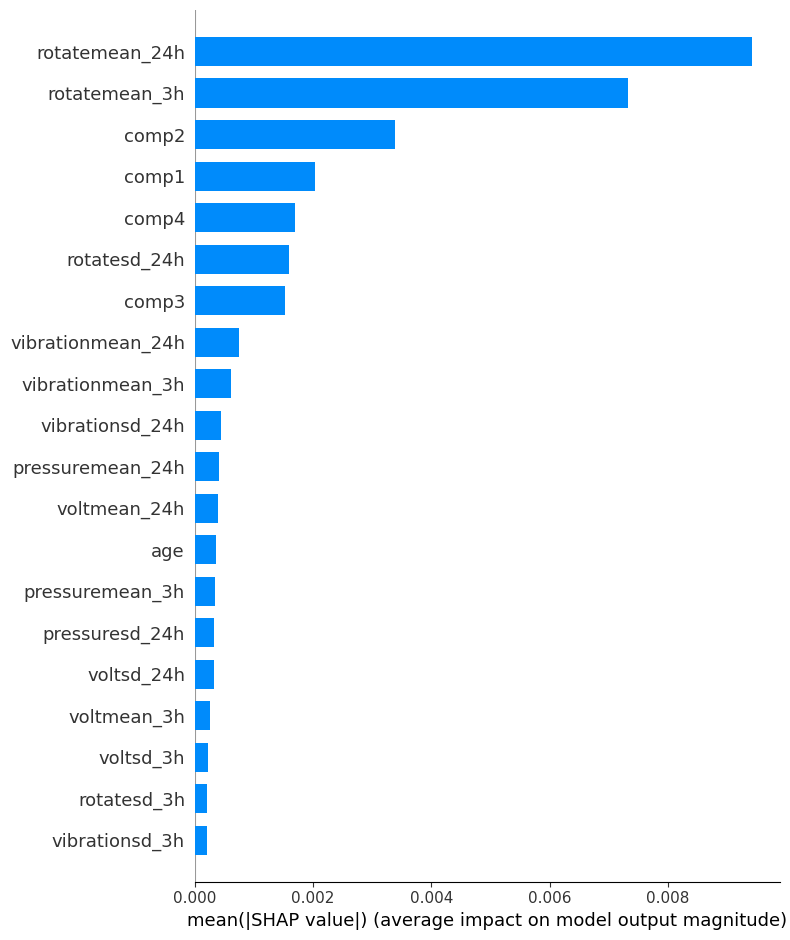

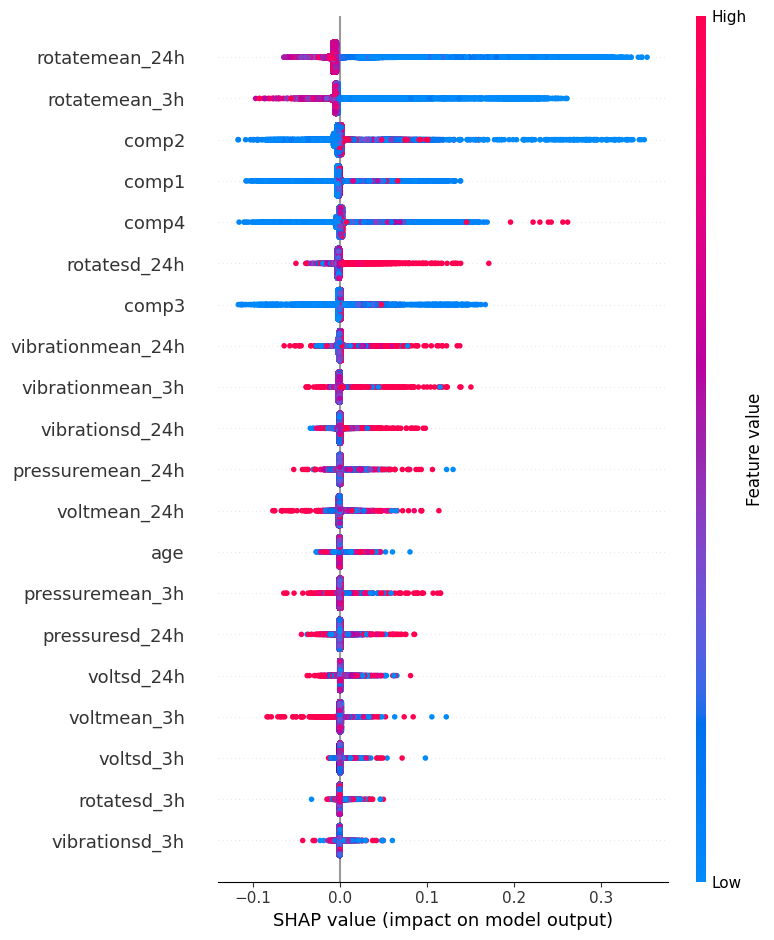

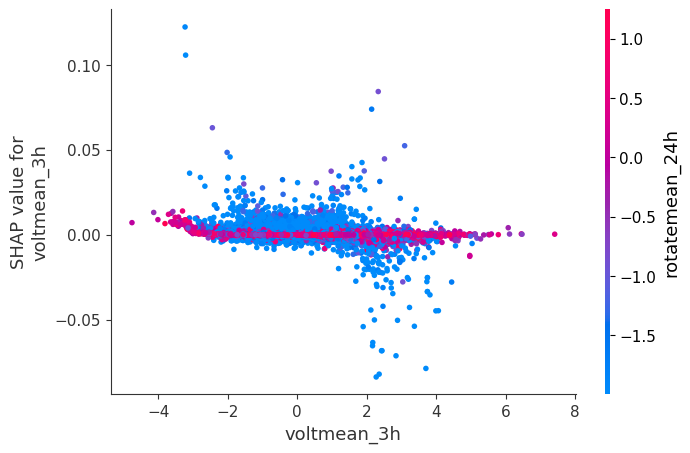

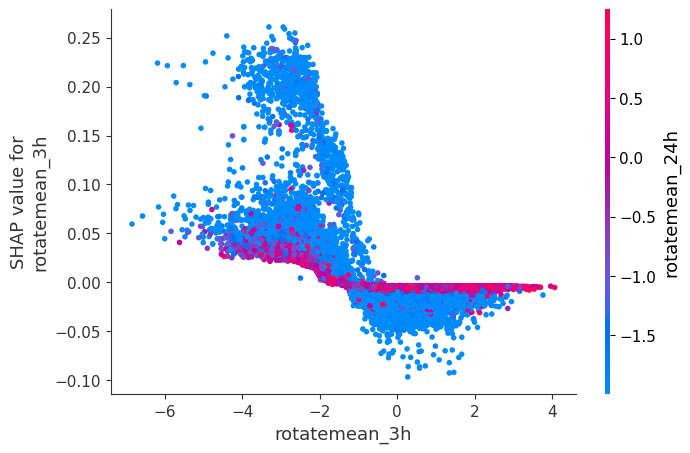

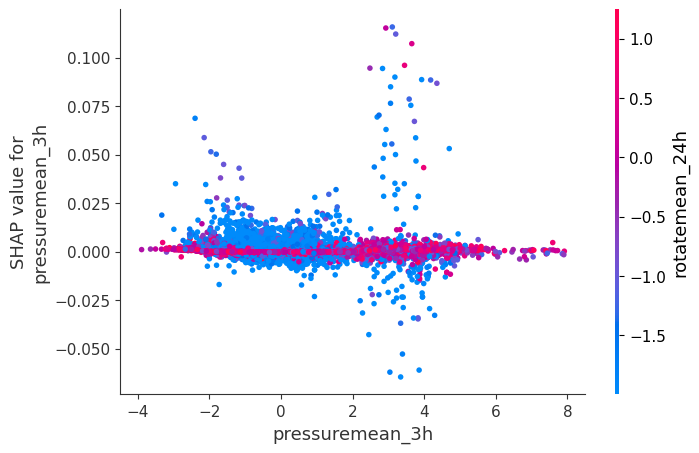

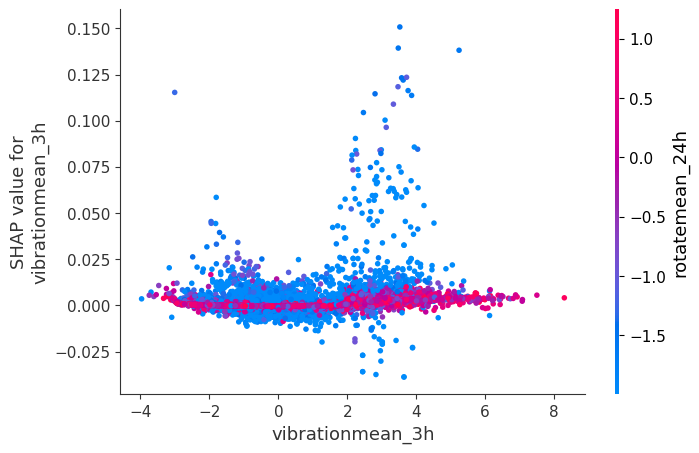

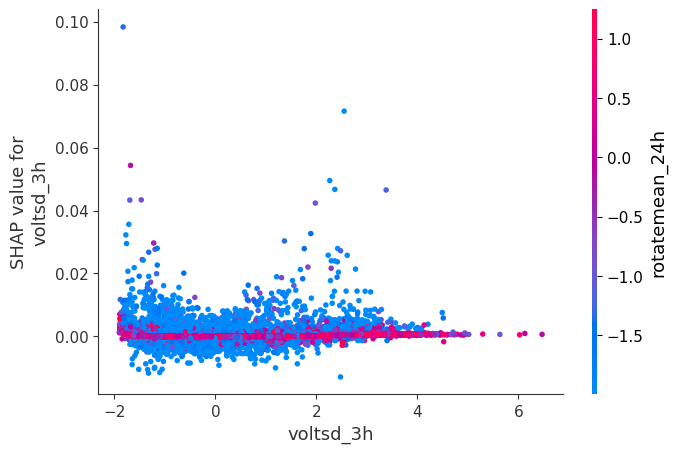

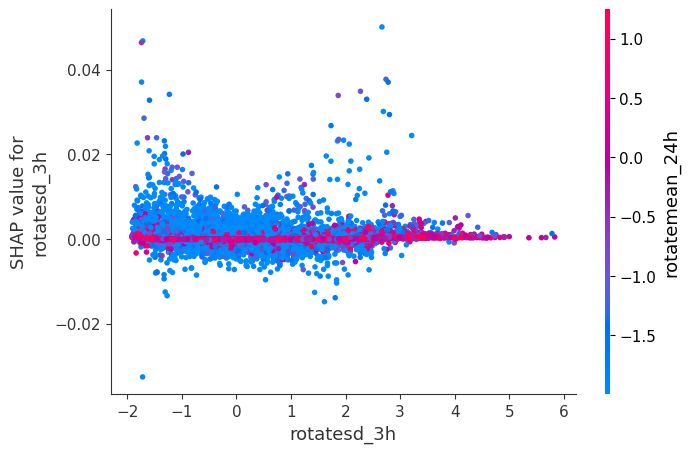

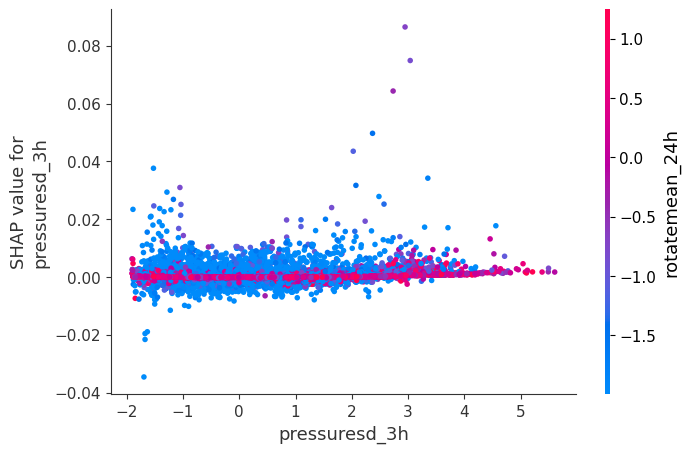

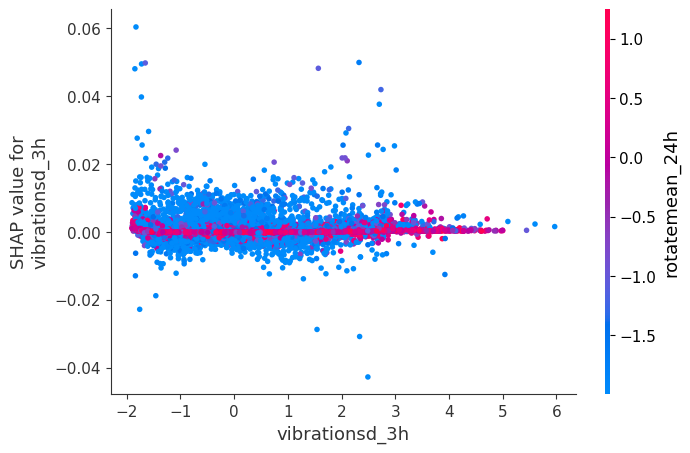

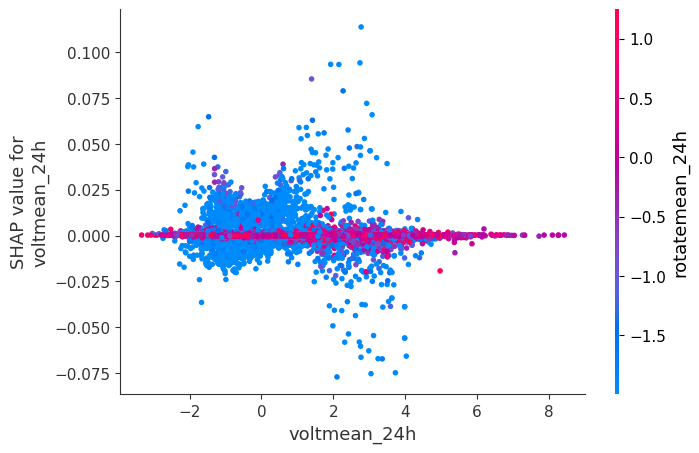

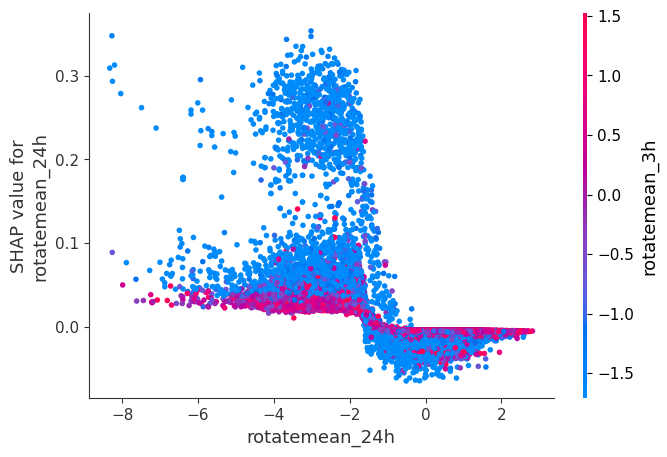

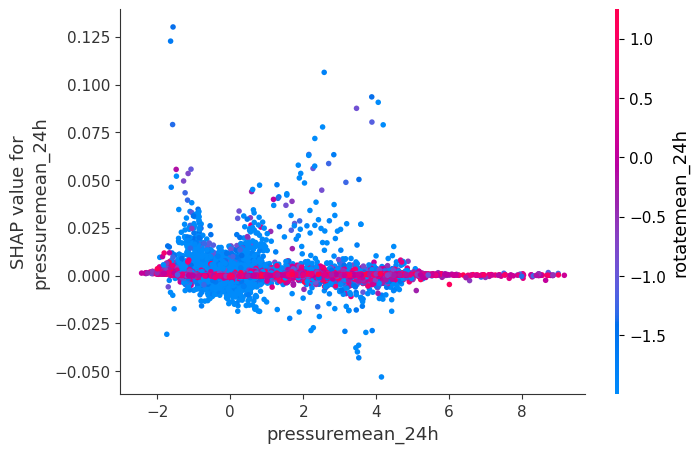

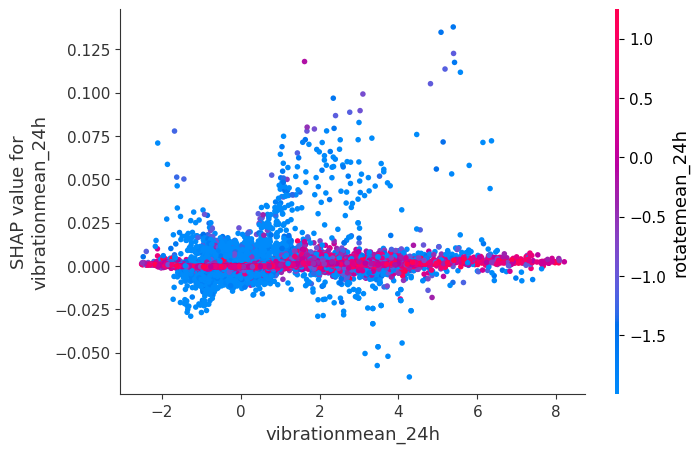

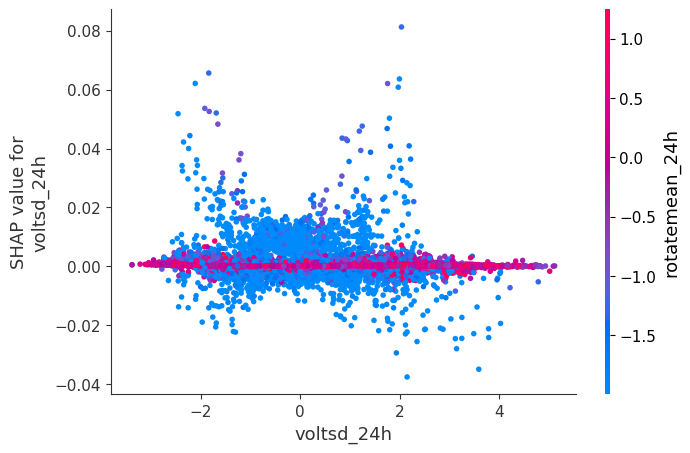

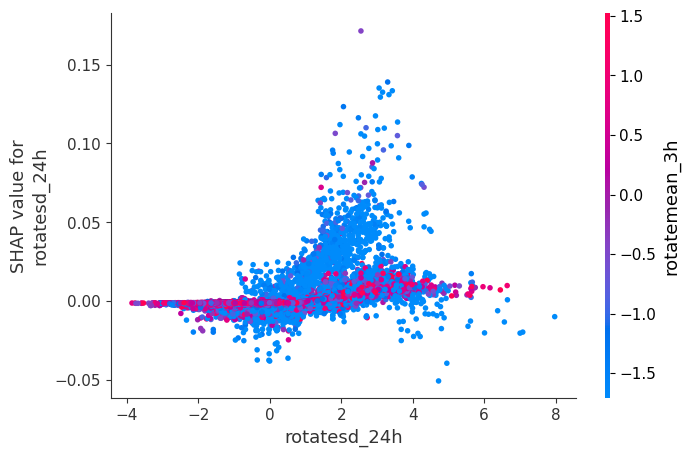

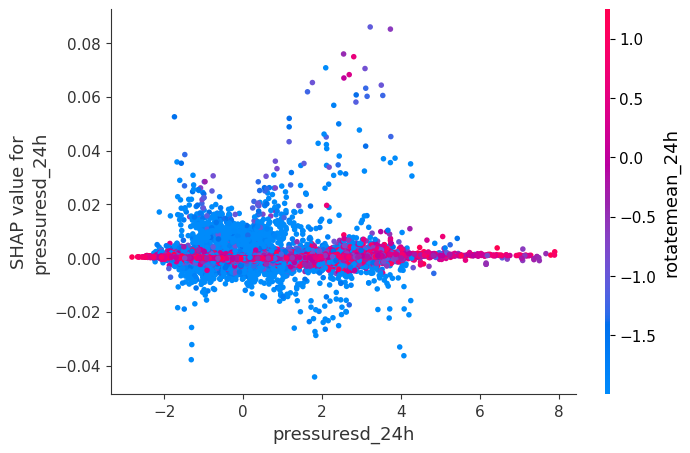

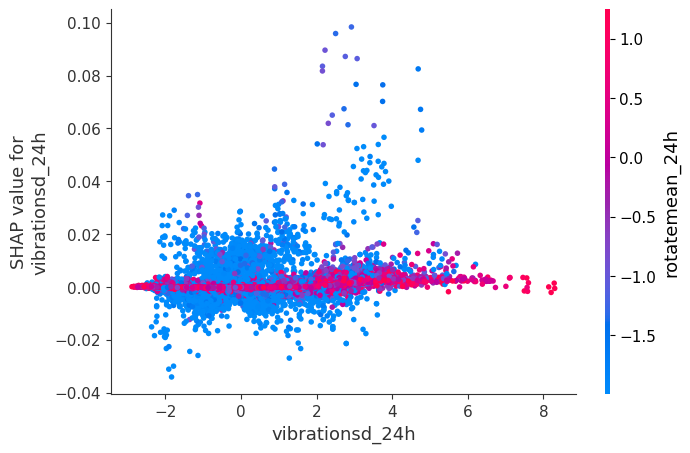

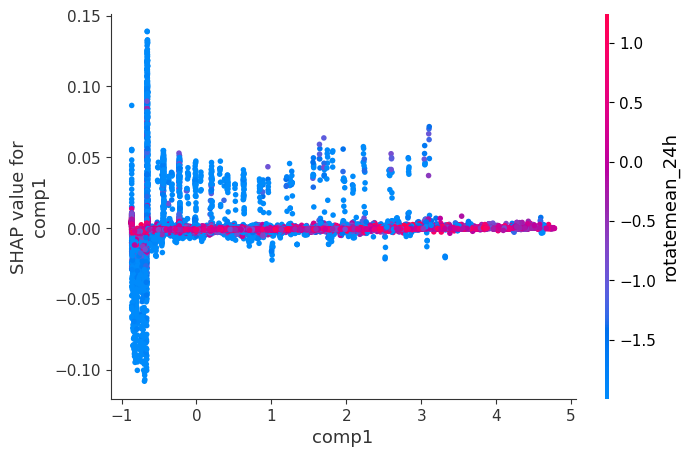

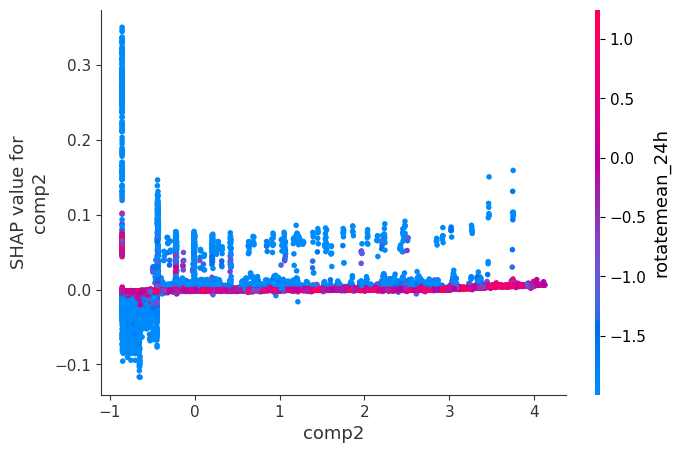

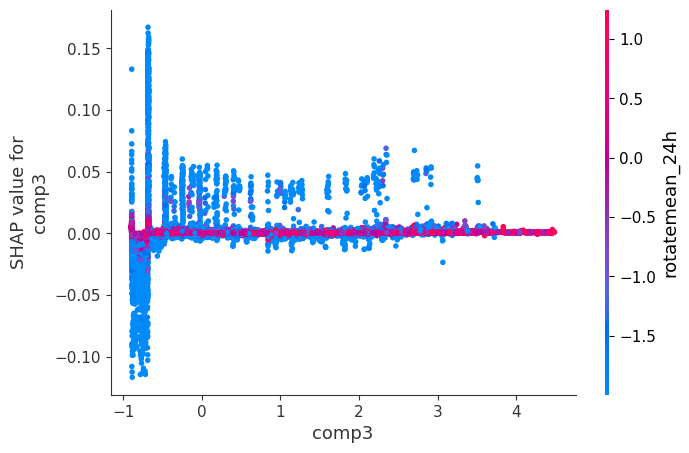

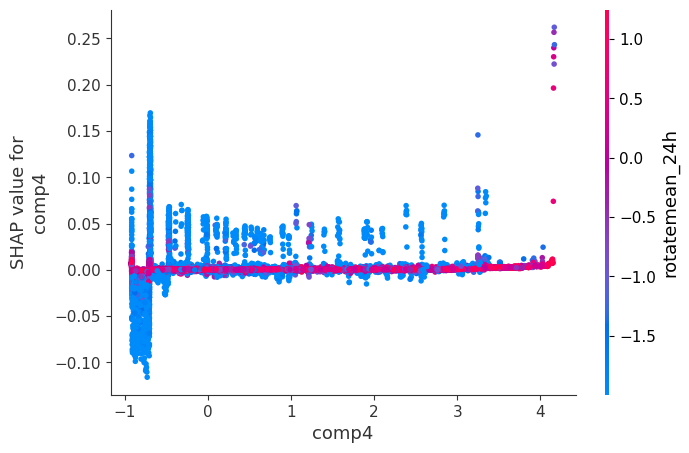

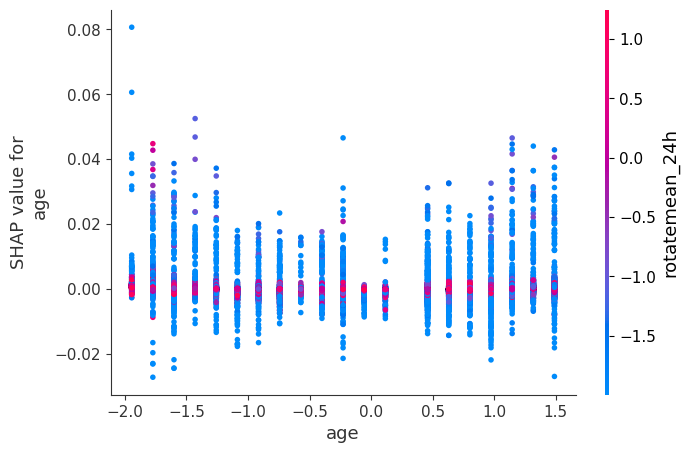

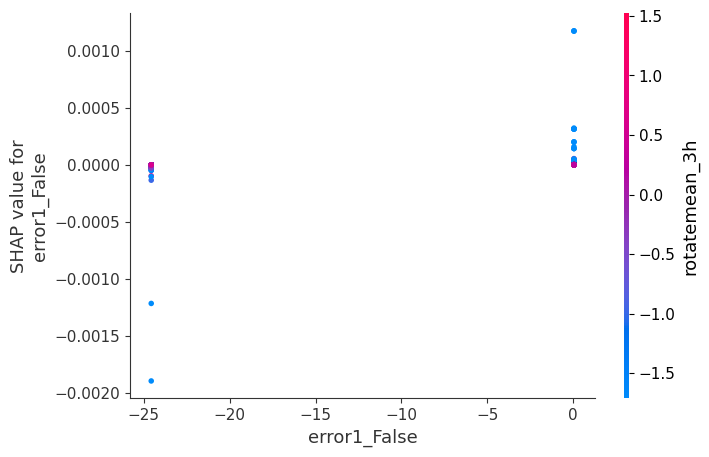

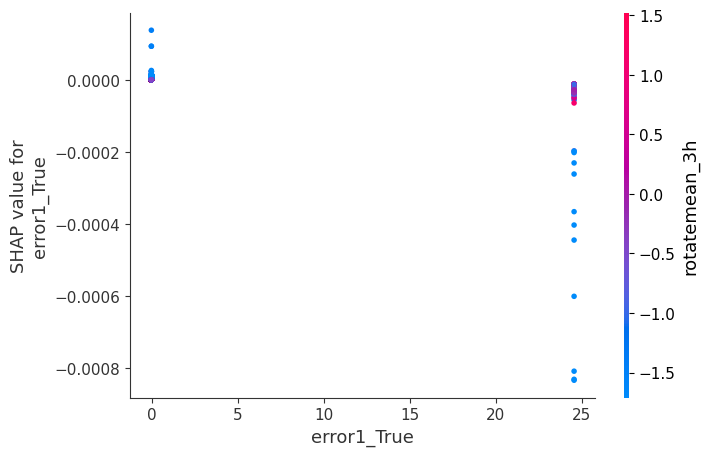

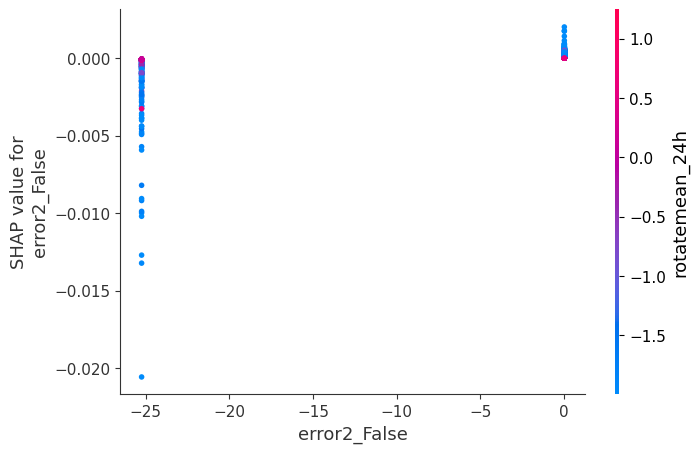

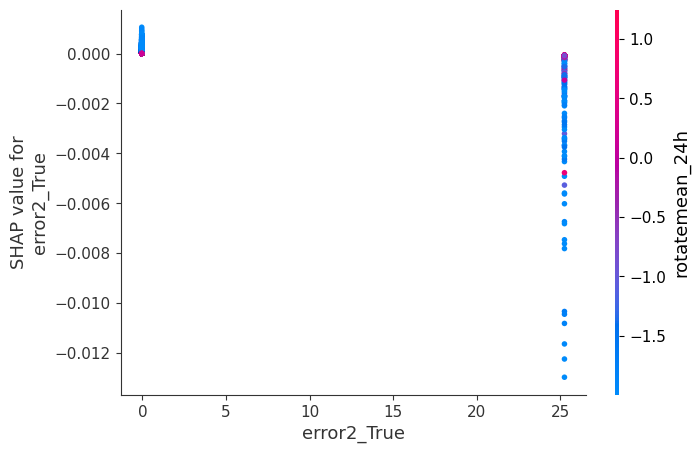

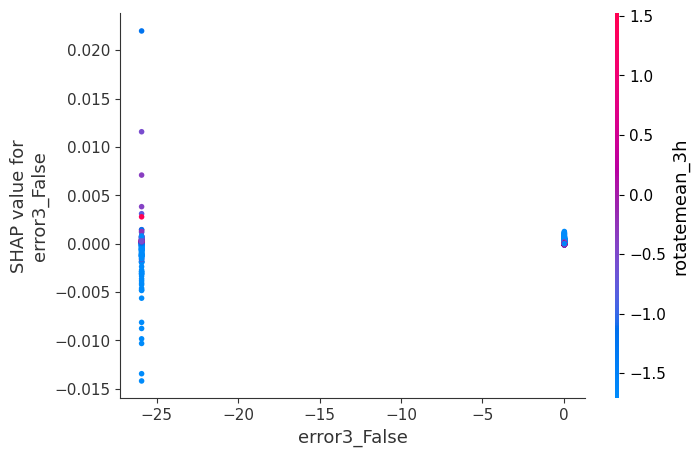

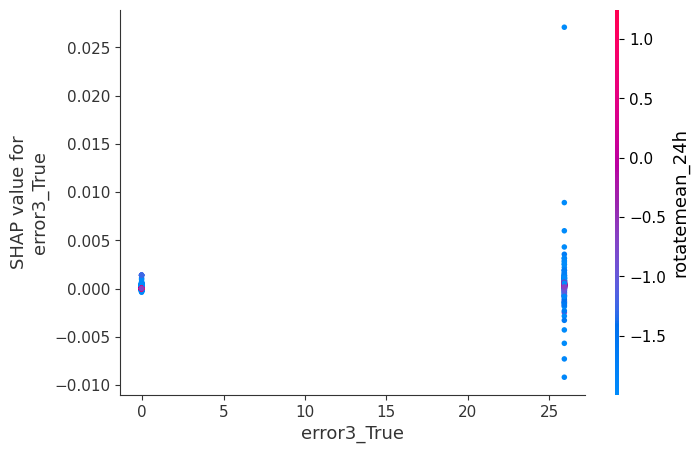

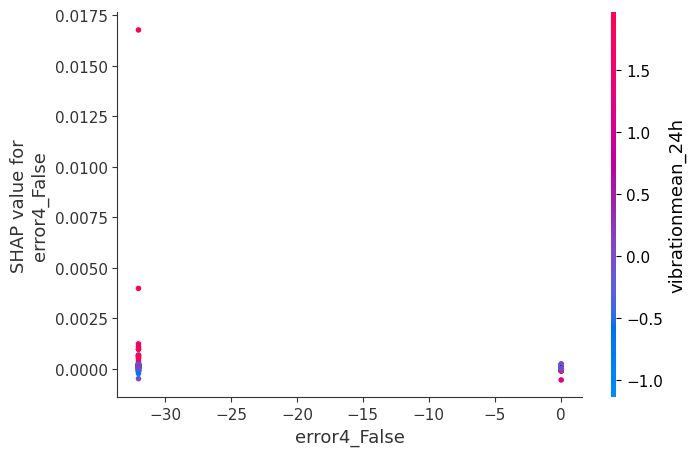

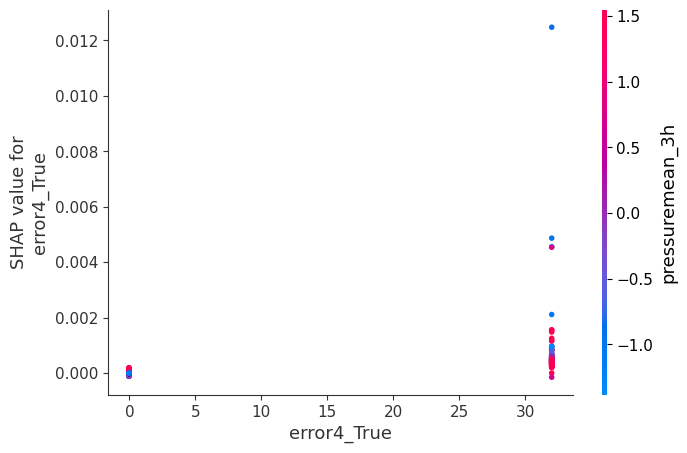

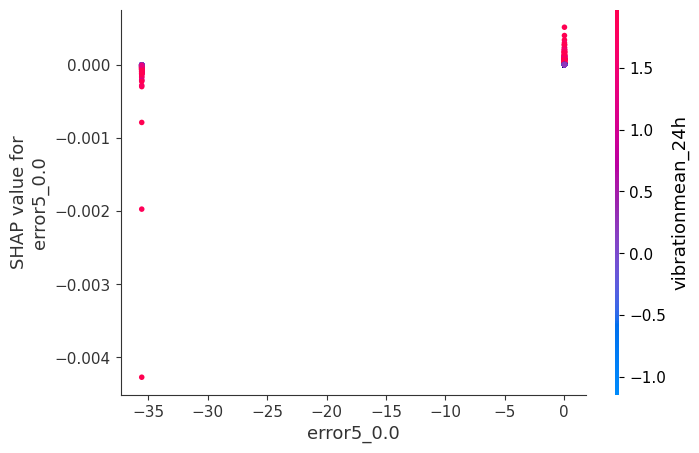

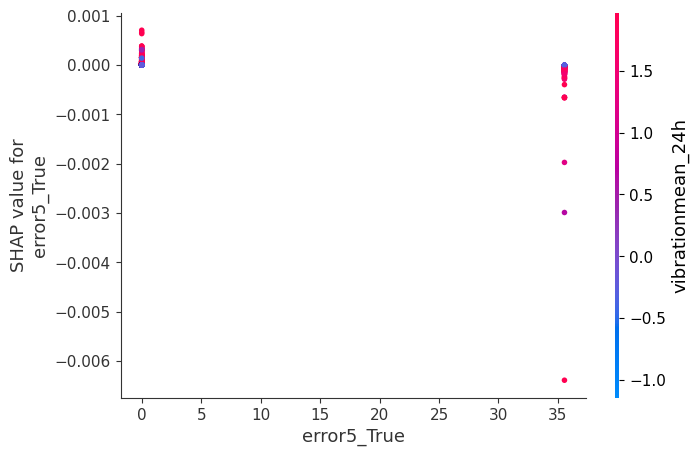

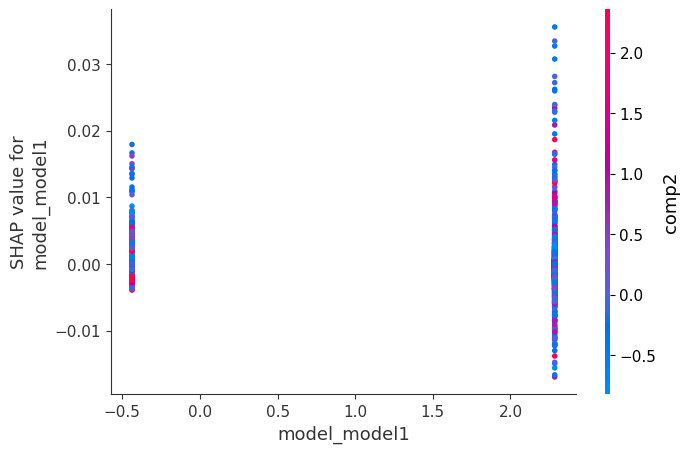

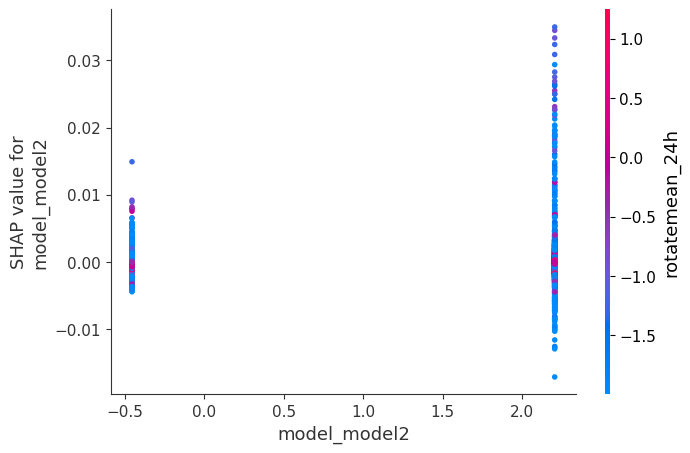

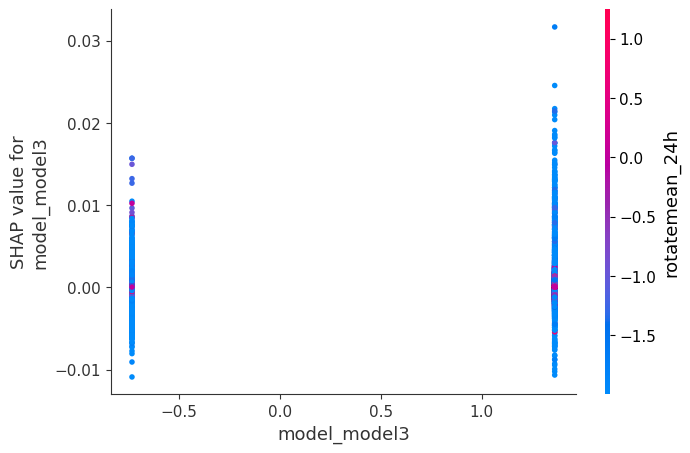

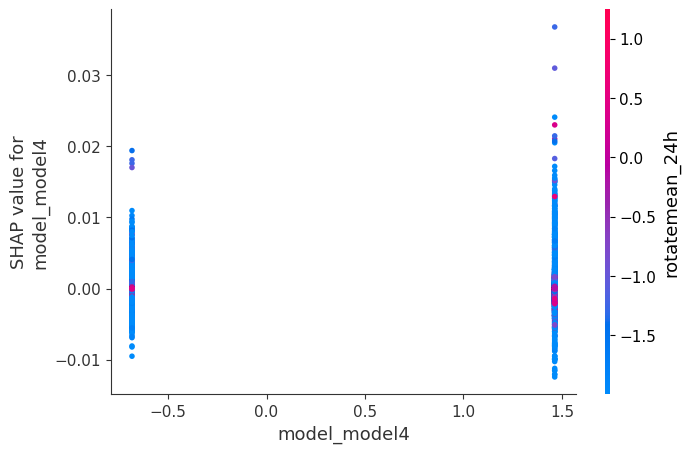

In [25]:
ai1.explain('shap')

In [26]:
ai1.result()

,Summary
Classifier,Random Forest Classifier
Accuracy,99.279731
YPred,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
